In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

In [2]:
mapTime = datetime.datetime( 2015, 4, 9, 7 )
vecsTime = datetime.datetime( 2015, 4, 9, 7 )
pltCoords = 'mlt'
cntrPotMin = -30.
cntrPotMax = 5.
inpDst = 0.
inpAsy = 20.
cntrLevels = numpy.linspace(cntrPotMin, cntrPotMax, 12, endpoint=True)

In [3]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
    # parameters from fitting
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []
dstIndSel = range(-150,10,10)
for z in dstIndSel:
    for x in range( -7, 8 ):
        for y in range( -12, 10 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            dstArr.append( z )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57. )
            probSapsArr.append( saps_pred_func(x,y,z) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= 0.\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,-12,-7,0.000737,12,50.0,-150
1,-11,-7,0.004760,13,50.0,-150
2,-10,-7,0.022901,14,50.0,-150
3,-9,-7,0.082052,15,50.0,-150
4,-8,-7,0.218907,16,50.0,-150


In [4]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func(asy):
    # parameters from fitting
    a_asy, b_asy = (-6.47, 9.48)
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

In [5]:
# To estimate the MLT variations we
# fit second order harmonics!
def mlt_fit_func(mlt, asy):
    # parameters from fitting
    c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b, phiC1_a,\
                 phiC1_b, phiS1_a, phiS1_b = (1.2138, 0.0171, -0.2115,\
                                              -0.0216, 0.7879, -0.0082,\
                                              -0.785, 0.005, 6.5243, 0.9407,\
                                              7.2761, 0.9453)
    
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    phiC1 = phiC1_a + phiC1_b*asy
    phiS1 = phiS1_a + phiS1_b*asy
    # Now get to the actual function
    phiC = (2*numpy.pi/24.) * mlt + phiC1
    phiS = (2*numpy.pi/24.) * mlt + phiS1
    cosTerm = c1 * numpy.cos(phiC)
    sinTerm = s1 * numpy.sin(phiS)
    cos2Term = c2 * numpy.cos(2*phiC)
    sin2Term = s2 * numpy.sin(2*phiS)
    return cosTerm + sinTerm + cos2Term + sin2Term

In [6]:
# MLAT varies with MLT and ASY. So we
# record MLAT variations as functions of
# MLT and Asy as well.
def mlat_mlt_fit_func(mlat, normMLT, asy):
    # parameters from fitting
    c0_a, c0_b, c0_c, c1_a, c1_b, c1_c, c2 = (\
            15.92788, -0.01479, 0.00207, -0.5999,\
            0.00028, -0.00013, 0.00565)    
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
    return c0 + c1*mlat + c2*numpy.square(mlat)

In [7]:
def saps_pot_func( asy, mlt, mlat ):
    # Estimate SAPS potentials by
    # combining all the different 
    # functions.
    normMLT = mlt
    if mlt > 12.:
        normMLT = mlt - 24.
    phiSaps = peak_pot_fit_func(asy)
#     print "phiSaps", phiSaps
    mltSaps = mlt_fit_func(mlt, asy)
#     print "mltSaps", mltSaps
    mlatMLTSaps = mlat_mlt_fit_func(mlat, normMLT, asy)
#     print "mlat-mlt-Saps", mlatMLTSaps
    return phiSaps*mltSaps*mlatMLTSaps

In [8]:
predPotArr = []
predMlatArr = []
predMltArr = []
predNormMltArr = []
predAsyArr = []

for cpMLT in range(24):
    for cpMlat in range(53,65,1):
        predMlatArr.append( cpMlat )
        predAsyArr.append( inpAsy )
        # Fit params
        predPotArr.append( saps_pot_func(inpAsy, cpMLT, cpMlat) )
        if cpMLT > 12.:
            normMlt = cpMLT - 24.
        else:
            normMlt = cpMLT
        predNormMltArr.append( normMlt )
        predMltArr.append(cpMLT)
    
predPotDF = pandas.DataFrame({
                "potential" : predPotArr,
                "Lat" : predMlatArr,
                "AsyH" : predAsyArr,
                "normMLT" : predNormMltArr,
                "MLT" : predMltArr
                })


In [9]:
selSapsPredDF = sapsPredDF[ sapsPredDF["dst_index"] == inpDst ].reset_index(drop=True)
predPotDF = predPotDF.merge( selSapsPredDF,\
                            on=[ "Lat", "MLT", "normMLT" ],\
                            how="inner" )
predPotDF = predPotDF.drop_duplicates()
predPotDF.head()

,AsyH,Lat,MLT,normMLT,potential,normLAT,probSAPS,dst_index
0,20.0,53,1,1.0,0.003674,-4,0.002837,0
1,20.0,54,1,1.0,0.180709,-3,0.011018,0
2,20.0,55,1,1.0,0.555423,-2,0.035072,0
3,20.0,56,1,1.0,1.127814,-1,0.091502,0
4,20.0,57,1,1.0,1.897884,0,0.195666,0


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


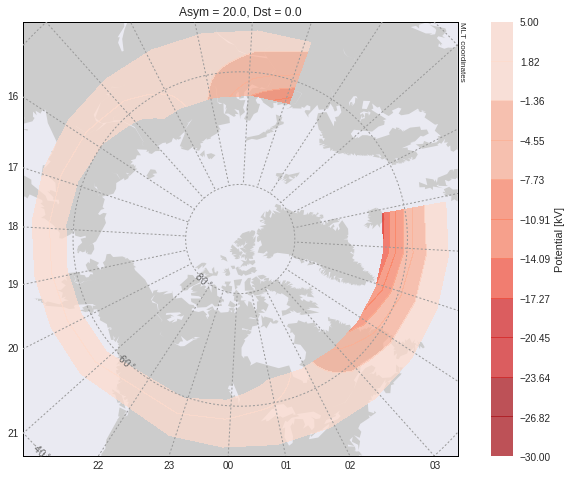

In [10]:
# seaborn color palette
seaMap = ListedColormap(sns.color_palette("Reds_r"))
fig = plt.figure(figsize=(12, 8))

pltDF = predPotDF[ ["Lat", "normMLT",\
                        "potential"] ].pivot( "Lat", "normMLT" )

mlatsPot = pltDF.index.values
nrmMltsPot = pltDF.columns.levels[1].values
mltsPot =[ x if x < 0. else x for x in nrmMltsPot ]
mlonPots = convert_mlt( mltsPot, vecsTime , m2a=True )
potVals=pltDF.values
#         nanLocs = numpy.isnan(potVals)
#         potVals[nanLocs] = 0
mltsPotCntr, mlatsPotCntr  = numpy.meshgrid( mltsPot, mlatsPot )
mlonsPotCntr, mlatsPotCntr  = numpy.meshgrid( mlonPots, mlatsPot )

ax = fig.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax, datetime=mapTime)

# remove the background map
# mapCommonColor = "0.95"
# m1.fillcontinents(color=mapCommonColor, lake_color=mapCommonColor)
# m1.drawmapboundary(fill_color=mapCommonColor)
# m1.drawcoastlines(color=mapCommonColor)


xVec, yVec = m1(mlonsPotCntr, mlatsPotCntr, coords=pltCoords)
cntrPlt = m1.contourf(xVec, yVec, potVals,cntrLevels,\
    zorder = 5., alpha=0.7,\
    cmap=seaMap, ax=ax);
ax.set_title( "Asym = " + str(inpAsy) +\
            ", Dst = " + str(inpDst) )
cbar = plt.colorbar(cntrPlt,ticks=cntrLevels)
cbar.set_clim( cntrPotMin, cntrPotMax )
cbar.ax.set_ylabel('Potential [kV]')
# cntrPlt.clim( cntrPotMin, cntrPotMax )
fig.savefig("../figs/potContrs.pdf",bbox_inches='tight')

In [13]:
print predPotDF[ predPotDF["potential"] > 5. ]

     AsyH  Lat  MLT  normMLT  potential  normLAT  probSAPS  dst_index
7    20.0   60    1      1.0   5.394161        3  0.580002          0
8    20.0   61    1      1.0   6.954943        4  0.559701          0
9    20.0   62    1      1.0   8.713403        5  0.442683          0
10   20.0   63    1      1.0  10.669541        6  0.286973          0
11   20.0   64    1      1.0  12.823356        7  0.152475          0
20   20.0   61    2      2.0   5.065600        4  0.312033          0
21   20.0   62    2      2.0   6.363845        5  0.219925          0
22   20.0   63    2      2.0   7.808222        6  0.127046          0
23   20.0   64    2      2.0   9.398730        7  0.060153          0
35   20.0   64    3      3.0   5.165692        7  0.018621          0
165  20.0   62   17     -7.0   5.168133        5  0.019292          0
166  20.0   63   17     -7.0   6.236384        6  0.031450          0
167  20.0   64   17     -7.0   7.411592        7  0.042023          0
175  20.0   60   18 